In [124]:
import glob
import os
import cv2
import glob
import importlib

import _pickle as pkl
import numpy as np
import pandas as pd

In [3]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils

In [188]:
datakey = '20190522_JC089_fov1'
experiment='rfs'

In [189]:
fit_results, fit_params = rfutils.load_fit_results(datakey, experiment='rfs')

In [211]:
eval_results, _ = rfutils.load_eval_results(datakey, 
                                         rfdir=fit_params['rfdir'])

In [212]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [213]:

fitdf = rfutils.rfits_to_df(fit_results, fit_params=fit_params,
                    scale_sigma=fit_params['scale_sigma'],
                    sigma_scale=fit_params['sigma_scale'])
fitdf = fitdf[fitdf['r2']>fit_params['fit_thr']] 
fitdf.head()

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2
85,1.111327,5.854219,45.961738,34.231365,0.216454,-0.004747,0.087992,0.631459
99,29.093374,4.722637,25.297816,36.419946,1.346117,-0.013190,0.201303,0.729386
115,-0.359113,25.227100,39.363303,31.265256,5.491278,-0.000514,0.089948,0.520312
122,3.931988,24.304596,31.689498,36.726465,6.074524,0.000724,0.086744,0.559490


In [214]:
fit_params['rfdir'].split('/traces/')[1].split('_')[0]

'traces001'

In [215]:
roi_list = sorted(list(fit_results.keys()))
fit_results.keys()

dict_keys([8, 34, 35, 38, 42, 71, 75, 85, 99, 107, 115, 116, 119, 122, 124, 128, 137, 138, 139, 143, 145])

In [216]:
trialdata, labels = rfutils.load_trialdata(fit_params) 
print(trialdata.shape)
roidf_list = [trialdata[[roi, 'config', 'trial']] for roi in roi_list] 
print(len(roidf_list))

--- processed traces: dff
(3218, 153)
21


In [199]:
# grid_points, cart_values, sphr_values = rfutils.coordinates_for_transformation(fit_params)

In [217]:
roi_df = roidf_list[0]
roi = int(np.unique([r for r in roi_df.columns if r not in ['config', 'trial']]))
print(roi)

8


In [218]:
responses_df = pd.concat([pd.Series(g[roi], name=c)\
                          .reset_index(drop=True)\
                          for c, g in roi_df.groupby(['config'])], axis=1)\
                .dropna(axis=0)        
responses_df.head()

,config001,config002,config003,config004,config005,config006,config007,config008,config009,config010,...,config222,config223,config224,config225,config226,config227,config228,config229,config230,config231
0,0.088802,0.082268,0.083594,0.394213,0.083014,-0.019299,0.019684,0.014170,0.000715,-0.056466,...,0.131693,-0.051860,0.081692,-0.025559,0.058455,0.118950,0.209998,-0.067164,-0.035368,0.050997
1,-0.038966,0.078507,0.025945,0.074145,0.039140,-0.029266,0.101995,0.089975,0.088247,-0.275126,...,0.052664,-0.017283,0.060977,-0.010288,0.014480,0.093032,-0.023654,0.046771,-0.035392,-0.014198
2,-0.052415,0.021872,0.182880,0.001324,0.164050,0.132536,0.084930,0.040462,0.110055,-0.095682,...,-0.077835,0.002186,-0.052675,-0.005013,0.071007,-0.002945,-0.112674,-0.086891,0.027839,0.015950
3,0.045231,0.109413,-0.039715,-0.035165,0.146111,0.012827,0.053949,0.144294,0.004154,-0.034032,...,0.077753,-0.032614,-0.098132,0.026587,0.058939,0.178565,-0.017151,0.012635,-0.072397,-0.053088
4,0.012412,0.193124,-0.063375,0.016835,-0.017494,0.045923,0.053670,0.149577,-0.018444,0.020561,...,0.061476,0.098676,-0.127758,-0.044008,0.111688,-0.034105,-0.008238,0.013623,-0.024243,0.045206


In [219]:
nx=len(fit_params['col_vals'])
ny=len(fit_params['row_vals'])
n_reps, n_conds = responses_df.shape
n_bootstrap_iters = 500 #fit_params['evaluation']['n_bootstrap_iters']

In [180]:
bootresp_ = pd.concat([responses_df.sample(n_reps, replace=True).mean(axis=0)
                   for ni in range(n_bootstrap_iters)], axis=1)
bootresp = bootresp_.apply(rfutils.reshape_array_for_nynx, args=(nx, ny))
bootresp.shape

In [183]:
param_order =['amp', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta', 'offset', 'r2']

do_spherical_correction = fit_params['do_spherical_correction']

min_sigma=2.5
max_sigma=50
row_vals = fit_params['row_vals']
col_vals = fit_params['col_vals']
xres=1 if do_spherical_correction else float(np.unique(np.diff(row_vals)))
yres=1 if do_spherical_correction else float(np.unique(np.diff(col_vals)))

sigma_scale=2.35
sigma_scale=1 if do_spherical_correction else sigma_scale 

In [184]:
bparams=[]
for ii in bootresp.columns:
    response_vector = bootresp[ii].values
    # nx=len(col_vals), ny=len(row_vals)
    rfmap = rfutils.get_rf_map(response_vector, nx, ny) 
    fitr, fit_y = rfutils.do_2d_fit(rfmap, nx=nx, ny=ny) 
    if fitr['success']:
        amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f = fitr['popt']
        if fit_params['do_spherical_correction']:
            # Correct for spher correction, if nec
            x0_f, y0_f, sigx_f, sigy_f = rfutils.get_scaled_sigmas(
                                                grid_points, sphr_values,
                                                x0_f, y0_f,
                                                sigx_f, sigy_f, theta_f,
                                                convert=True)
            fitr['popt'] = (amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f) 
        if any(s<min_sigma for s \
                in [abs(sigx_f)*xres*sigma_scale, abs(sigy_f)*yres*sigma_scale])\
                or any(s > max_sigma for s \
                in [abs(sigx_f)*xres*sigma_scale, abs(sigy_f)*yres*sigma_scale]):
            fitr['success'] = False
    # If the fit for current bootstrap sample is good, 
    # add it to dataframe of bootstrapped rf params
    if fitr['success']:
        #amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f = fitr['popt']
        curr_fit_results = list(fitr['popt'])
        curr_fit_results.append(fitr['r2'])
        bparams.append(tuple(curr_fit_results)) #(fitr['popt'])       
paramsdf = pd.DataFrame(data=np.array(bparams),
                        columns = param_order)
paramsdf['cell'] = roi

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:728: RuntimeWarning: The number of zeros exceeds mest
  warnings.warn(RuntimeWarning("The number of zeros exceeds mest"))


In [222]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [225]:
%matplotlib notebook

<IPython.core.display.Javascript object>


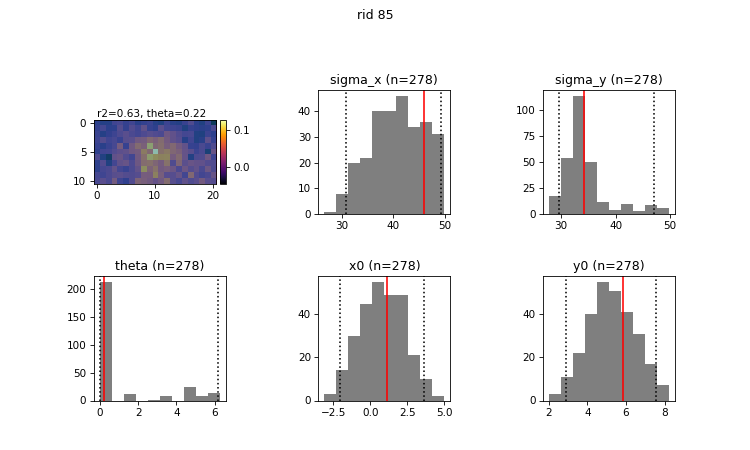

In [226]:
rid = 85
rfmap = fit_results[rid]['data']       
bootdfs = eval_results['bootdf']
bootdf_roi = bootdfs[bootdfs['cell']==rid]    
fig = rfutils.plot_roi_evaluation(rid, fitdf.loc[rid], rfmap, bootdf_roi)

In [227]:
params = ['amplitude', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta', 'offset', 'r2']   

In [231]:
import analyze2p.extraction.rois as roiutils

In [253]:
fitdf_roi = fitdf.loc[rid]
fitdf_roi[params]
session, animalid, fovn = hutils.split_datakey_str(datakey)      
traceid='traces001'
fovcoords = roiutils.load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovn,
                                     traceid=traceid, create_new=False)     
posdf = pd.concat([fitdf,
                   fovcoords['roi_positions'].loc[fitdf.index]], axis=1)
posdf = posdf.rename(columns={'x0': 'xpos_rf', 'y0': 'ypos_rf', 
                              'ml_pos': 'xpos_fov', 'ap_pos': 'ypos_fov'})
posdf

,xpos_rf,ypos_rf,sigma_x,sigma_y,theta,offset,amplitude,r2,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,xpos_fov,ypos_fov
85,1.111327,5.854219,45.961738,34.231365,0.216454,-0.004747,0.087992,0.631459,463.204697,201,542.559687,285,430.240313,714.395303
99,29.093374,4.722637,25.297816,36.419946,1.346117,-0.013190,0.201303,0.729386,695.959295,302,603.478669,317,369.321331,481.640705
115,-0.359113,25.227100,39.363303,31.265256,5.491278,-0.000514,0.089948,0.520312,467.813699,203,801.465362,421,171.334638,709.786301
122,3.931988,24.304596,31.689498,36.726465,6.074524,0.000724,0.086744,0.559490,504.685714,219,856.673190,450,116.126810,672.914286


In [266]:
importlib.reload(rfutils)
%matplotlib notebook

In [267]:
reliable_rois = eval_results['reliable_rois'] 
len(reliable_rois)

3

<IPython.core.display.Javascript object>


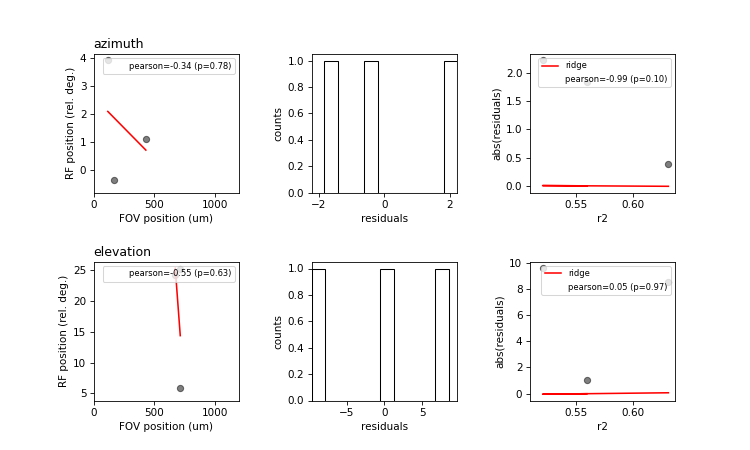

[azimuth] Mean squared error: 1.68 | Variance score: 0.11
[elevation] Mean squared error: 7.45 | Variance score: 0.30


In [268]:
fig = rfutils.plot_linear_regr_by_condition( posdf.loc[reliable_rois],model='ridge')


In [270]:
rfutils.compare_regr_to_boot_params(eval_results, posdf, outdir=evaldir)

NameError: name 'evaldir' is not defined